# Day 15 Hyperparameter Tuning & Optimization

In this notebook, we explore **Hyperparameter Tuning & Optimization**, a crucial phase in developing high-performing machine learning models.

While model architecture defines *what* a model can learn, **hyperparameters** determine *how effectively* it learns. The right combination improves performance, enhances generalization, and prevents overfitting.

---

## 1. Import Required Libraries

In [3]:
!pip install optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import optuna  # For Bayesian Optimization



## 2. Load and Prepare the Dataset

In [4]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 455, Testing samples: 114


## 3. Baseline Model (No Tuning)

In [5]:
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## 4. Grid Search Cross-Validation

In [6]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9604


## 5. Random Search Cross-Validation

In [7]:
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_:.4f}")

Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}
Best Score: 0.9582


## 6. Bayesian Optimization with Optuna

In [8]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return roc_auc_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(f"Best Trial: {study.best_trial.params}")

[I 2025-10-13 23:06:22,069] A new study created in memory with name: no-name-e861c3ab-3293-4ca0-966d-cc476a37400f
[I 2025-10-13 23:06:23,090] Trial 0 finished with value: 0.9503968253968255 and parameters: {'n_estimators': 395, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9503968253968255.
[I 2025-10-13 23:06:23,897] Trial 1 finished with value: 0.9503968253968255 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9503968253968255.
[I 2025-10-13 23:06:24,394] Trial 2 finished with value: 0.9503968253968255 and parameters: {'n_estimators': 193, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9503968253968255.
[I 2025-10-13 23:06:25,052] Trial 3 finished with value: 0.9503968253968255 and parameters: {'n_estimators': 248, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value:

Best Trial: {'n_estimators': 395, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 5}


## 7. Evaluate the Best Model

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



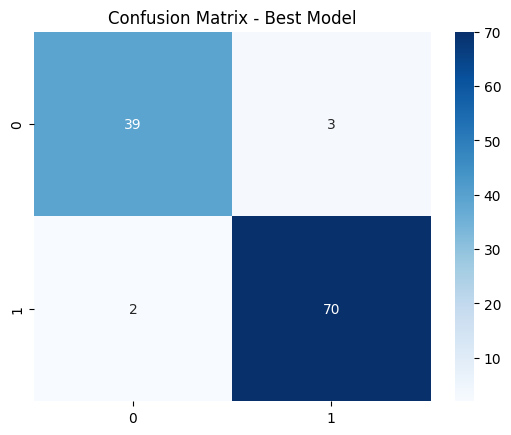

In [9]:
best_model = RandomForestClassifier(**study.best_trial.params, random_state=42)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

print(classification_report(y_test, y_pred_best))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Best Model')
plt.show()

## ✨ 8. Key Takeaways
- **Hyperparameter tuning** transforms average models into high-performing, production-ready systems.
- **Grid Search** ensures exhaustive exploration, while **Random Search** provides efficiency.
- **Bayesian Optimization (Optuna)** intelligently navigates the parameter space.
- The goal is to balance exploration, accuracy, and computational cost.

Optimization ensures that models not only perform well in development but also **generalize effectively** in real-world scenarios.